#  QAM Demodulation in Nonlinear Channels with Deep Neural Networks

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates:
* demodulation of QAM symbols in highly nonlinear channels using an artificial neural network
* utilization of softmax layer
* variable batch size to improve learning towards lower error rates

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cuda


Specify the parameters of the transmission as the fiber length $L$ (in km), the fiber nonlinearity coefficienty $\gamma$ (given in 1/W/km) and the total noise power $P_n$ (given in dBM. The noise is due to amplified spontaneous emission in amplifiers along the link). We assume a model of a dispersion-less fiber affected by nonlinearity. The model, which is described for instance in [1] is given by an iterative application of the equation
$$
x_{k+1} = x_k\exp\left(\jmath\frac{L}{K}\gamma|x_k|^2\right) + n_{k+1},\qquad 0 \leq k < K
$$
where $x_0$ is the channel input (the modulated, complex symbols) and $x_K$ is the channel output. $K$ denotes the number of steps taken to simulate the channel Usually $K=50$ gives a good approximation.

[1] S. Li, C. Häger, N. Garcia, and H. Wymeersch, "Achievable Information Rates for Nonlinear Fiber Communication via End-to-end Autoencoder Learning," Proc. ECOC, Rome, Sep. 2018

In [2]:
# Length of transmission (in km)
L = 5000

# fiber nonlinearity coefficient
gamma = 1.27

Pn = -21.3 # noise power (in dBm)

Kstep = 50 # number of steps used in the channel model

# noise variance per step    
sigma_n = np.sqrt((10**((Pn-30)/10)) / Kstep / 2)    

constellations = {'16-QAM': np.array([-3,-3,-3,-3,-1,-1,-1,-1,1,1,1,1,3,3,3,3]) + 1j*np.array([-3,-1,1,3,-3,-1,1,3,-3,-1,1,3,-3,-1,1,3]), \
                  '16-APSK': np.array([1,-1,0,0,1.4,1.4,-1.4,-1.4,3,-3,0,0,5,-5,0,0]) + 1j*np.array([0,0,1,-1,1.4,-1.4,1.4,-1.4,0,0,4,-4,0,0,6,-6]), \
                  '4-test' : np.array([-1,2,0,4]) + 1j*np.array([0,0,3,0])}

# permute constellations so that it is visually more appealing with the chosen colormap
for cname in constellations.keys():
    constellations[cname] = constellations[cname][np.random.permutation(len(constellations[cname]))]


def simulate_channel(x, Pin, constellation):  
    # modulate bpsk
    input_power_linear = 10**((Pin-30)/10)
    norm_factor = 1 / np.sqrt(np.mean(np.abs(constellation)**2)/input_power_linear)
    modulated = constellation[x] * norm_factor
    

    temp = np.array(modulated, copy=True)
    for i in range(Kstep):
        power = np.absolute(temp)**2
        rotcoff = (L / Kstep) * gamma * power
        
        temp = temp * np.exp(1j*rotcoff) + sigma_n*(np.random.randn(len(x)) + 1j*np.random.randn(len(x)))
    return temp

We consider BPSK transmission over this channel.

Show constellation as a function of the fiber input power. When the input power is small, the effect of the nonlinearity is small (as $\jmath\frac{L}{K}\gamma|x_k|^2 \approx 0$) and the transmission is dominated by the additive noise. If the input power becomes larger, the effect of the noise (the noise power is constant) becomes less pronounced, but the constellation rotates due to the larger input power and hence effect of the nonlinearity.

In [3]:
length_plot = 4000

def plot_constellation(Pin, constellation_name):
    constellation = constellations[constellation_name]
        
    t = np.random.randint(len(constellation),size=length_plot)
    r = simulate_channel(t, Pin, constellation)

    plt.figure(figsize=(12,6))
    font = {'size'   : 14}
    plt.rc('font', **font)
    plt.rc('text', usetex=matplotlib.checkdep_usetex(True))
    plt.subplot(1,2,1)
    r_tx = constellation[range(len(constellation))]
    plt.scatter(np.real(r_tx), np.imag(r_tx), c=range(len(constellation)), marker='o', s=200, cmap='tab20')
    plt.xticks(())
    plt.yticks(())
    plt.axis('equal')
    plt.xlabel(r'$\Re\{r\}$',fontsize=14)
    plt.ylabel(r'$\Im\{r\}$',fontsize=14)
    plt.title('Transmitted constellation')
    
    plt.subplot(1,2,2)
    plt.scatter(np.real(r), np.imag(r), c=t, cmap='tab20',s=4)
    plt.xlabel(r'$\Re\{r\}$',fontsize=14)
    plt.ylabel(r'$\Im\{r\}$',fontsize=14)
    plt.axis('equal')
    plt.title('Received constellation ($L = %d$\,km, $P_{in} = %1.2f$\,dBm)' % (L, Pin))    
    #plt.savefig('%s_received_zd_%1.2f.pdf' % (constellation_name.replace('-','_'),Pin),bbox_inches='tight')
    
interactive_update = interactive(plot_constellation, \
                                 Pin = widgets.FloatSlider(min=-10.0,max=10.0,step=0.1,value=1, continuous_update=False, description='Input Power Pin (dBm)', style={'description_width': 'initial'}, layout=widgets.Layout(width='50%')), \
                                 constellation_name = widgets.RadioButtons(options=['16-QAM','16-APSK','4-test'], value='16-QAM',continuous_update=False,description='Constellation'))


output = interactive_update.children[-1]
output.layout.height = '400px'
interactive_update

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Input Power Pin (dBm)', lay…

Helper function to compute Bit Error Rate (BER)

In [8]:
# helper function to compute the symbol error rate
def SER(predictions, labels):
    return (np.sum(np.argmax(predictions, 1) != labels) / predictions.shape[0])

Here, we define the parameters of the neural network and training, generate the validation set and a helping set to show the decision regions

In [18]:
# set input power
Pin = -5

#define constellation
constellation = constellations['16-APSK']

input_power_linear = 10**((Pin-30)/10)
norm_factor = 1 / np.sqrt(np.mean(np.abs(constellation)**2)/input_power_linear)
sigma = np.sqrt((10**((Pn-30)/10)) / Kstep / 2)


constellation_mat = np.stack([constellation.real * norm_factor, constellation.imag * norm_factor],axis=1)


# validation set. Training examples are generated on the fly
N_valid = 100000

# number of neurons in hidden layers
hidden_neurons_1 = 50
hidden_neurons_2 = 50
hidden_neurons_3 = 50
hidden_neurons_4 = 50



y_valid = np.random.randint(len(constellation),size=N_valid)
r = simulate_channel(y_valid, Pin, constellation)

# find extension of data (for normalization and plotting)
ext_x = max(abs(np.real(r)))
ext_y = max(abs(np.imag(r)))
ext_max = max(ext_x,ext_y)*1.2

# scale data to be between 0 and 1
X_valid = torch.from_numpy(np.column_stack((np.real(r), np.imag(r))) / ext_max).float().to(device)


# meshgrid for plotting
mgx,mgy = np.meshgrid(np.linspace(-ext_max,ext_max,200), np.linspace(-ext_max,ext_max,200))
meshgrid = torch.from_numpy(np.column_stack((np.reshape(mgx,(-1,1)),np.reshape(mgy,(-1,1)))) / ext_max).float().to(device)

This is the main neural network with 4 hidden layers, each with ELU activation function. Note that the final layer does *not* use a `softmax` function, as this function is already included in the `CrossEntropyLoss`.

In [19]:
class Receiver_Network(nn.Module):
    def __init__(self, hidden_neurons_1, hidden_neurons_2, hidden_neurons_3, hidden_neurons_4):
        super(Receiver_Network, self).__init__()
        # Linear function, 2 input neurons (real and imaginary part)        
        self.fc1 = nn.Linear(2, hidden_neurons_1) 

        # Non-linearity
        self.activation_function = nn.ELU()
       
        # Linear function (hidden layer)
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)  
        
        # Another hidden layer
        self.fc3 = nn.Linear(hidden_neurons_2, hidden_neurons_3)
        
        # Another hidden layer
        self.fc4 = nn.Linear(hidden_neurons_3, hidden_neurons_4)
        
        # Output layer
        self.fc5 = nn.Linear(hidden_neurons_4, len(constellation))
        

    def forward(self, x):
        # Linear function, first layer
        out = self.fc1(x)

        # Non-linearity, first layer
        out = self.activation_function(out)
        
        # Linear function, second layer
        out = self.fc2(out)
        
        # Non-linearity, second layer
        out = self.activation_function(out)
        
        # Linear function, third layer
        out = self.fc3(out)

        # Non-linearity, third layer
        out = self.activation_function(out)
        
        # Linear function, fourth layer
        out = self.fc4(out)
        
        # Non-linearity, fourth layer
        out = self.activation_function(out)

        # Linear function, output layer
        out = self.fc5(out)
        
        # Do *not* apply softmax, as it is already included in the CrossEntropyLoss
        
        return out

This is the main learning function, generate the data directly on the GPU (if available) and the run the neural network. We use a variable batch size that varies during training. In the first iterations, we start with a small batch size to rapidly get to a working solution. The closer we come towards the end of the training we increase the batch size. If keeping the batch size small, it may happen that there are no misclassifications in a small batch and there is no incentive of the training to improve. A larger batch size will most likely contain errors in the batch and hence there will be incentive to keep on training and improving. 

Here, the data is generated on the fly inside the graph, by using PyTorchs random number generation. As PyTorch does not natively support complex numbers (at least in early versions), we decided to replace the complex number operations in the channel by an equivalent simple rotation matrix and treating real and imaginary parts separately.

We employ the Adam optimization algorithm. Here, the epochs are not defined in the classical way, as we do not have a training set per se. We generate new data on the fly and never reuse data.

In [20]:
model = Receiver_Network(hidden_neurons_1, hidden_neurons_2, hidden_neurons_3, hidden_neurons_4)
model.to(device)

# Cross Entropy loss accepting logits at input
loss_fn = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer = optim.Adam(model.parameters())  

# Softmax function
softmax = nn.Softmax(dim=1)

num_epochs = 100
batches_per_epoch = 500

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs)

validation_SERs = np.zeros(num_epochs)
decision_region_evolution = []


constellation_tensor = torch.from_numpy(constellation_mat).float().to(device)

for epoch in range(num_epochs):
    batch_labels = torch.empty(int(batch_size_per_epoch[epoch]), device=device)
    noise = torch.empty((int(batch_size_per_epoch[epoch]),2), device=device, requires_grad=False)        

    for step in range(batches_per_epoch):
        # sample new mini-batch directory on the GPU (if available)        
        batch_labels.random_(len(constellation))

        temp_onehot = torch.zeros(int(batch_size_per_epoch[epoch]), len(constellation), device=device)
        temp_onehot[range(temp_onehot.shape[0]), batch_labels.long()]=1
        
        # channel simulation directly on the GPU
        qam = (temp_onehot @ constellation_tensor).to(device)
        
        for i in range(Kstep):
            power = torch.norm(qam, dim=1) ** 2
            rotcoff = (L / Kstep) * gamma * power
            noise.normal_(mean=0, std=sigma) # sample noise
            
            # phase rotation due to nonlinearity
            temp1 = qam[:,0] * torch.cos(rotcoff) - qam[:,1] * torch.sin(rotcoff)            
            temp2 = qam[:,0] * torch.sin(rotcoff) + qam[:,1] * torch.cos(rotcoff)            
            qam = torch.stack([temp1, temp2], dim=1) + noise

        qam = qam / ext_max
        outputs = model(qam)

        # compute loss
        loss = loss_fn(outputs.squeeze(), batch_labels.long())
        
        # compute gradients
        loss.backward()
        
        optimizer.step()
        # reset gradients
        optimizer.zero_grad()
        
    # compute validation SER
    out_valid = softmax(model(X_valid))
    validation_SERs[epoch] = SER(out_valid.detach().cpu().numpy(), y_valid)
    
    print('Validation SER after epoch %d: %f (loss %1.8f)' % (epoch, validation_SERs[epoch], loss.detach().cpu().numpy()))                
        
    # store decision region for generating the animation    
    mesh_prediction = softmax(model(meshgrid))    
    decision_region_evolution.append(0.195*mesh_prediction.detach().cpu().numpy() + 0.4)


Validation SER after epoch 0: 0.087910 (loss 0.25666699)
Validation SER after epoch 1: 0.073710 (loss 0.27054536)
Validation SER after epoch 2: 0.069440 (loss 0.18978219)
Validation SER after epoch 3: 0.072350 (loss 0.18784641)
Validation SER after epoch 4: 0.065310 (loss 0.20270868)
Validation SER after epoch 5: 0.066920 (loss 0.18670554)
Validation SER after epoch 6: 0.065250 (loss 0.19986154)
Validation SER after epoch 7: 0.065620 (loss 0.15918072)
Validation SER after epoch 8: 0.064780 (loss 0.17279980)
Validation SER after epoch 9: 0.065180 (loss 0.15178823)
Validation SER after epoch 10: 0.066590 (loss 0.19182576)
Validation SER after epoch 11: 0.065040 (loss 0.17501570)
Validation SER after epoch 12: 0.064370 (loss 0.15596694)
Validation SER after epoch 13: 0.065760 (loss 0.15842058)
Validation SER after epoch 14: 0.066080 (loss 0.18166625)
Validation SER after epoch 15: 0.064720 (loss 0.17574421)
Validation SER after epoch 16: 0.067980 (loss 0.17383322)
Validation SER after epo

Plt decision region and scatter plot of the validation set. Note that the validation set is **only** used for computing BERs and plotting, there is no feedback towards the training!

In [21]:
cmap = matplotlib.cm.tab20
base = plt.cm.get_cmap(cmap)
color_list = base.colors
new_color_list = [[t/2 + 0.5 for t in color_list[k]] for k in range(len(color_list))]

# find minimum SER from validation set
min_SER_iter = np.argmin(validation_SERs)

<IPython.core.display.Javascript object>


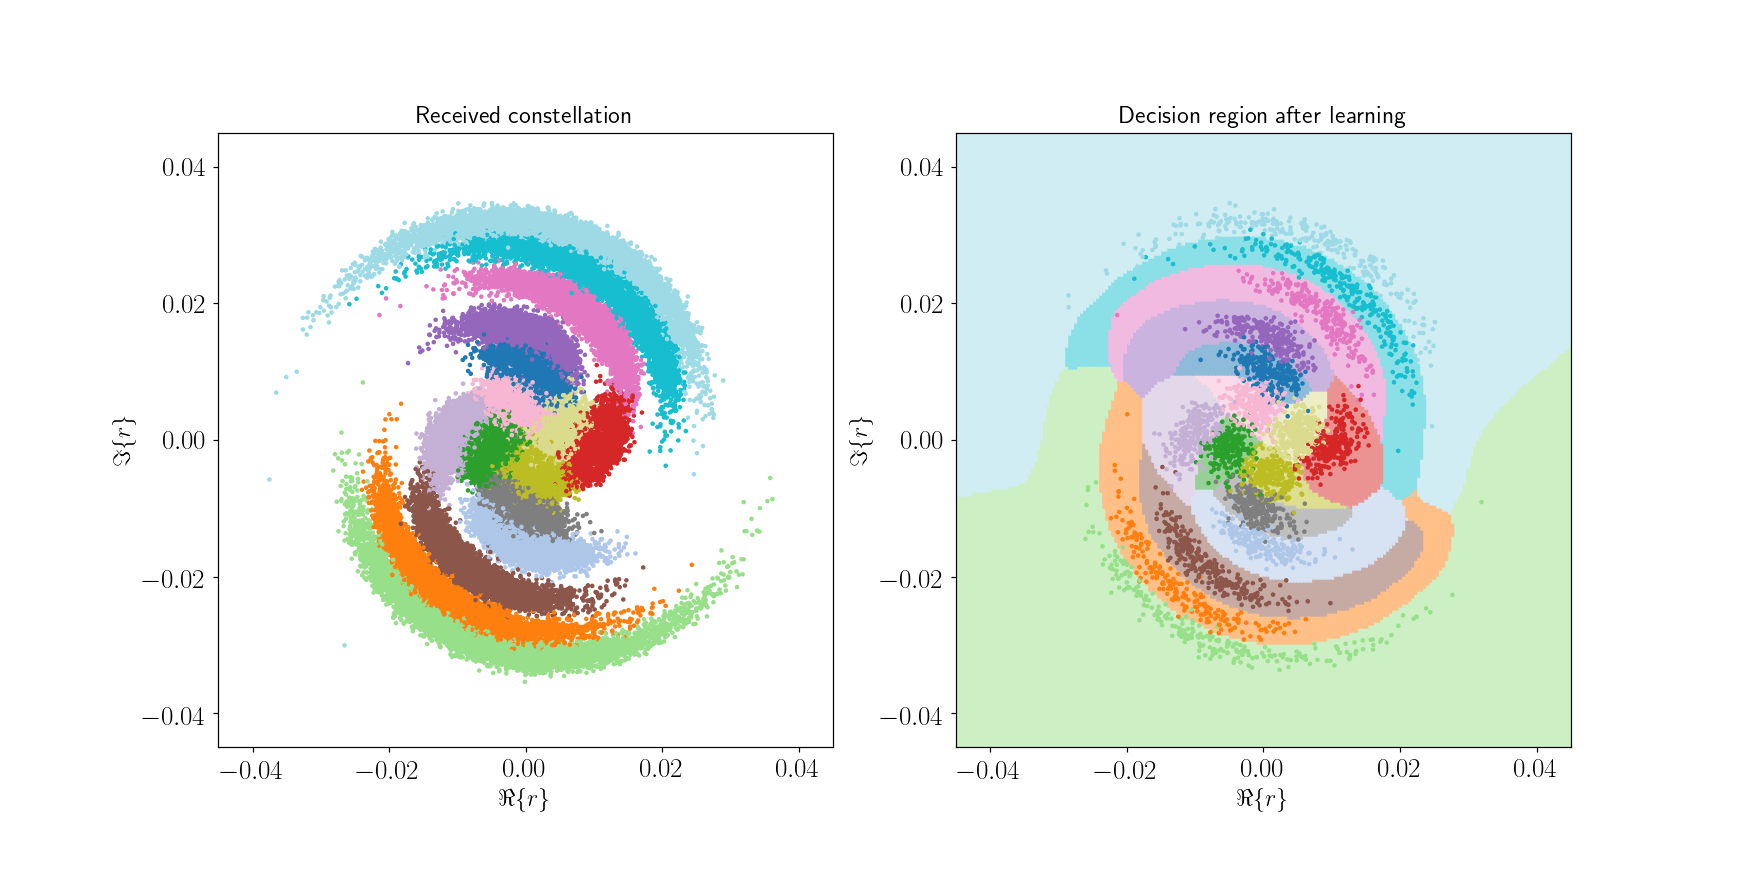

Text(0.5, 1.0, 'Decision region after learning')

In [23]:
plt.figure(figsize=(16,8))
plt.subplot(121)
#plt.contourf(mgx,mgy,decision_region_evolution[-1].reshape(mgy.shape).T,cmap='coolwarm',vmin=0.3,vmax=0.7)
plt.scatter(X_valid.cpu()[:,0]*ext_max, X_valid.cpu()[:,1]*ext_max, c=y_valid, cmap='tab20',s=4)
plt.axis('scaled')
plt.xlabel(r'$\Re\{r\}$',fontsize=16)
plt.ylabel(r'$\Im\{r\}$',fontsize=16)
plt.xlim((-ext_max,ext_max))
plt.ylim((-ext_max,ext_max))
plt.title('Received constellation',fontsize=16)

#light_tab20 = cmap_map(lambda x: x/2 + 0.5, matplotlib.cm.tab20)
plt.subplot(122)
decision_scatter = np.argmax(decision_region_evolution[min_SER_iter], 1)
plt.scatter(meshgrid.cpu()[:,0] * ext_max, meshgrid.cpu()[:,1] * ext_max, c=decision_scatter, cmap=matplotlib.colors.ListedColormap(colors=new_color_list),s=4)
plt.scatter(X_valid.cpu()[0:4000,0]*ext_max, X_valid.cpu()[0:4000,1]*ext_max, c=y_valid[0:4000], cmap='tab20',s=4)
plt.axis('scaled')
plt.xlim((-ext_max,ext_max))
plt.ylim((-ext_max,ext_max))
plt.xlabel(r'$\Re\{r\}$',fontsize=16)
plt.ylabel(r'$\Im\{r\}$',fontsize=16)
plt.title('Decision region after learning',fontsize=16)

#plt.savefig('decision_region_16APSK_Pin%d.pdf' % Pin,bbox_inches='tight')

Generate animation and save as a gif.

<IPython.core.display.Javascript object>


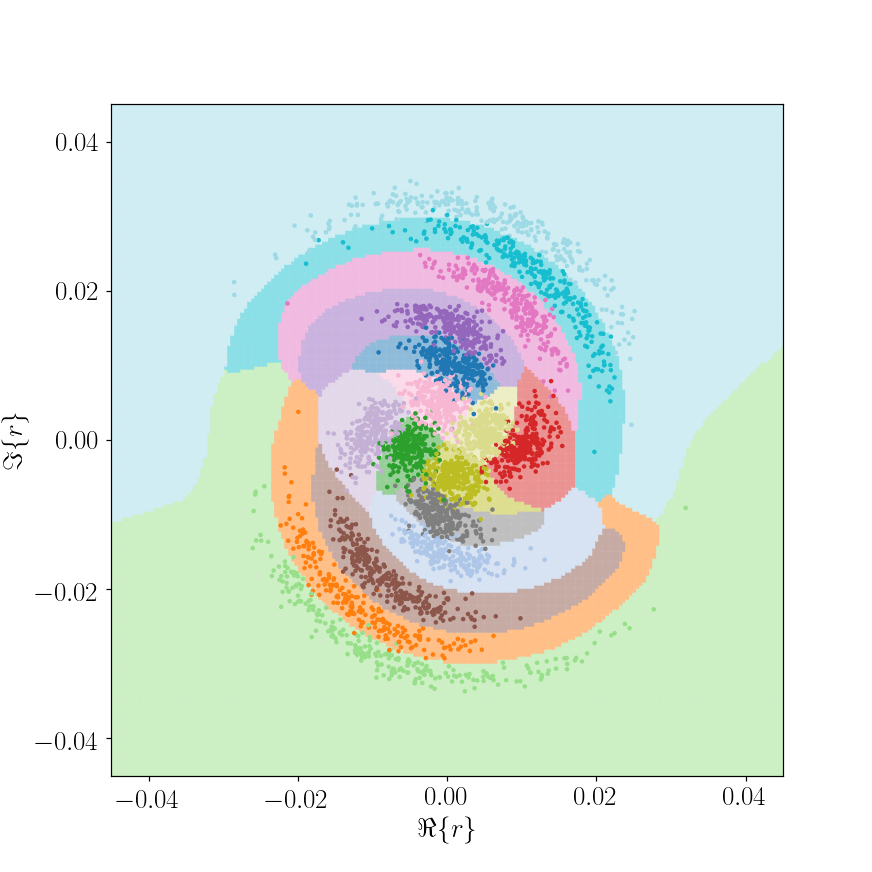

In [24]:
%matplotlib notebook
%matplotlib notebook
# Generate animation
from matplotlib import animation, rc
from matplotlib.animation import PillowWriter # Disable if you don't want to save any GIFs.

font = {'size'   : 18}
plt.rc('font', **font)

fig, ax = plt.subplots(1, figsize=(8,8))
ax.axis('scaled')

written = False
def animate(i):
    ax.clear()
    decision_scatter = np.argmax(decision_region_evolution[i], 1)
    
    plt.scatter(meshgrid.cpu()[:,0] * ext_max, meshgrid.cpu()[:,1] * ext_max, c=decision_scatter, cmap=matplotlib.colors.ListedColormap(colors=new_color_list),s=4, marker='s')
    plt.scatter(X_valid.cpu()[0:4000,0]*ext_max, X_valid.cpu()[0:4000,1]*ext_max, c=y_valid[0:4000], cmap='tab20',s=4)
    ax.set_xlim(( -ext_max, ext_max))
    ax.set_ylim(( -ext_max, ext_max))

    ax.set_xlabel(r'$\Re\{r\}$',fontsize=18)
    ax.set_ylabel(r'$\Im\{r\}$',fontsize=18)

    
anim = animation.FuncAnimation(fig, animate, frames=min_SER_iter+1, interval=200, blit=False)
fig.show()
#anim.save('learning_decision_16APSK_Pin%d_varbatch.gif' % Pin, writer=PillowWriter(fps=5))